In [1]:
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
from datetime import datetime

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2

from smc.smc import sequential_monte_carlo
from smc.sampling_algorithms import (
    systematic_resample,
    stratified_resample,
    multinomial_resample
)
from smc.utils import lambda_schedule
from datasets_local import gaussian_mixture

from smc_scripts.plot_utils import plot_smc_results_checkerboard, calculate_EMD
from smc.proposals import (
    reverse_as_proposal, 
    first_order_approximation_optimal_proposal, 
    first_order_approximation_optimal_proposal_with_gradient_clipping
)

from utils.metadata import save_metadata_json, get_metadata

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


## Load pre-trained mdm model

In [2]:
from models.discrete_diffusion.mdm import MaskedDiffusion
from models.discrete_diffusion.utils.parametrizations import (
    subs_parametrization,
    subs_parametrization_continuous,
)
from models.denoising_models.mlp import MLP

batch_size = 64
vocab_size = 64
num_categories = vocab_size + 1  #includes the mask category
mask_index = num_categories - 1
input_shape = (2,)
num_timesteps = 100

pretrained_model = MaskedDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=64,
        encode_time=False,
        n_hidden_layers=2,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
pretrained_model.load_state_dict(torch.load('../model_weights/mdm_gmm_type1_64_copy.pth'))

pretrained_model_with_subs_continuous = MaskedDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=64,
        encode_time=False,
        n_hidden_layers=2,
        probs_parametrization_fn=subs_parametrization_continuous,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
pretrained_model_with_subs_continuous.load_state_dict(torch.load('../model_weights/mdm_gmm_type1_64_copy.pth'))

<All keys matched successfully>

## Define Reward, KL penalty coefficient, and Corresponding Target Distribution

In [3]:
def compute_rewards(x: Tensor, with_grad=False):
    # x.shape : (B, 2, num_categories)
    
    x0 = torch.arange(0, vocab_size, device=x.device).float() / (vocab_size - 1)
    x1 = torch.arange(0, vocab_size, device=x.device).float() / (vocab_size - 1)
    
    reward_x0 = - ((x0 - 0.5) * 12) ** 2 / 100
    reward_x1 = - ((x1 - 0.5) * 12) ** 2 
    
    reward = (x[:, 0, :-1] * reward_x0 + x[:, 1, :-1] * reward_x1).sum(dim=-1)
    return reward

kl_weight = 1.  

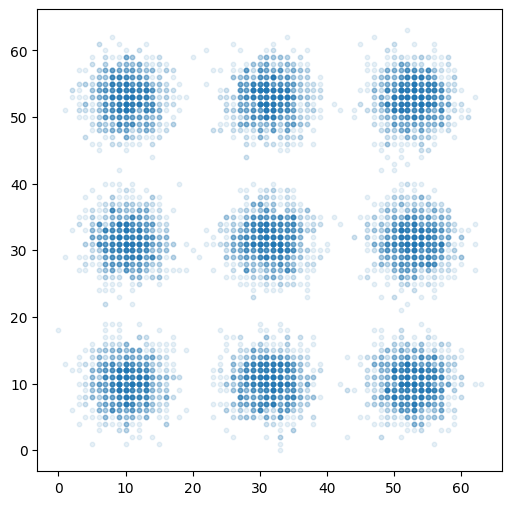

In [4]:
# Visualize pre-trained model samples
pretrained_model.eval()
with torch.no_grad():
    pretrained_model_samples = pretrained_model.sample(num_samples=10000, device=device).cpu().numpy()
plt.figure(figsize=(6, 6))
plt.scatter(pretrained_model_samples[:, 0], pretrained_model_samples[:, 1], s=10, alpha=0.1)
plt.show()

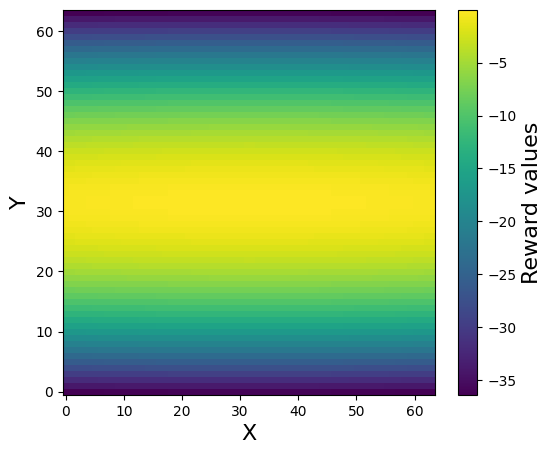

In [5]:
def get_rewards_for_grid():
    grid = torch.stack(torch.meshgrid(torch.arange(vocab_size), torch.arange(vocab_size), indexing='ij'), dim=-1)
    rewards_for_grid = compute_rewards(
        F.one_hot(grid.reshape(-1, 2), num_classes=num_categories).float()
    ).reshape(vocab_size, vocab_size)
    return rewards_for_grid.to(device)

def plot_heatmap(t, save_file=None):
    """
    Plots a 2D tensor/array as a heatmap.
    """
    if hasattr(t, "detach"):  # likely a torch tensor
        t = t.detach().cpu().numpy()
    import numpy as np
    t = np.asarray(t)
    assert t.ndim == 2, f"Expected 2D data, got shape {t.shape}"
    
    plt.figure(figsize=(6, 5))
    plt.imshow(t.T, origin='lower', aspect='auto', cmap='viridis')
    plt.xlabel('X', fontsize=16)
    plt.ylabel('Y', fontsize=16)
    cbar = plt.colorbar()
    cbar.set_label('Reward values', fontsize=16)
    if save_file is not None:
        plt.savefig(save_file, bbox_inches='tight', format=save_file.split(".")[-1])
    plt.show()
    
rewards_for_grid = get_rewards_for_grid()
plot_heatmap(rewards_for_grid, 'plots/gmm1_reward_heatmap.pdf')

In [6]:
def intialize_particles(num_particles, device=device):
    particles = torch.full((num_particles, *input_shape), mask_index, device=device, requires_grad=False)
    return particles

num_particles = 2000
ESS_min = num_particles / 2
# lambdas = lambda_schedule(num_timesteps)
lambda_tempering = False
if lambda_tempering:
    lambdas = np.linspace(1, 0, num_timesteps+1)
else:
    lambdas = np.ones(num_timesteps+1)
perform_final_resample = True

reward_estimate = "exact"  # "exact" or "MC estimate"
reward_estimate_sample_count = 100

In [7]:
metadata = get_metadata(dict(locals()), ignore_internal=True)
metadata

{'batch_size': 64,
 'vocab_size': 64,
 'num_categories': 65,
 'mask_index': 64,
 'num_timesteps': 100,
 'kl_weight': 1.0,
 'num_particles': 2000,
 'ESS_min': 1000.0,
 'lambda_tempering': False,
 'perform_final_resample': True,
 'reward_estimate': 'exact',
 'reward_estimate_sample_count': 100}

In [8]:
base_dir = "outputs/smc_mdm_gmm1"
cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")
outputs_dir = f"{base_dir}/{cur_time}"
os.makedirs(outputs_dir, exist_ok=True)

save_metadata_json(metadata, outputs_dir)

runs_per_method = 10

BASE_MODEL = "BASE_MODEL"
TARGET_DIST = "TARGET"
SMC_LOP = "SMC_LOP"
SMC_RP = "SMC_RP"
SMC_FALOP = "SMC_FALOP"

all_experiment_results = {
    BASE_MODEL: [],
    SMC_LOP: [],
    SMC_RP: [],
    SMC_FALOP: [],
    TARGET_DIST: [],
}

Metadata saved to outputs/smc_mdm_gmm1/20250903-120831/metadata.json


### Use Importance sampling with num_particles * 100 particles to get target distribution samples

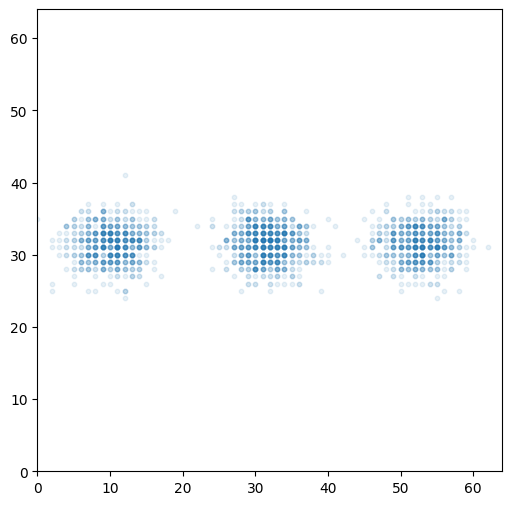

Target Reward: -0.30418115854263306
Diversity: 432


In [9]:
def target_distribution_log_pdf(x, kl_weight):
    reward = compute_rewards(F.one_hot(x, num_classes=num_categories).float())
    return reward / kl_weight

def sample_target_distribution(n_samples, kl_weight):
    samples = gaussian_mixture.generate_samples(type="1", n_grid_points=vocab_size, batch_size=n_samples * 100)
    log_pdf_values = target_distribution_log_pdf(samples, kl_weight)
    indices = torch.distributions.Categorical(logits=log_pdf_values).sample((n_samples,))
    return samples[indices]

target_samples = sample_target_distribution(num_particles, kl_weight)

plt.figure(figsize=(6, 6))
plt.scatter(target_samples[:, 0], target_samples[:, 1], s=10, alpha=0.1)
plt.xlim(0, vocab_size)
plt.ylim(0, vocab_size)
plt.show()

target_rewards = compute_rewards(F.one_hot(target_samples, num_classes=num_categories).float())
target_samples_reward = target_rewards.mean().item()
print(f"Target Reward: {target_samples_reward}")
target_samples_diversity = np.unique(target_samples, axis=0).shape[0]
print(f"Diversity: {target_samples_diversity}")

all_experiment_results[TARGET_DIST].append({
    "results": {
        "X_0": target_samples,
    },
    "metrics": {
        "reward": target_samples_reward,
        "diversity": target_samples_diversity,
        "emd": 0.0,
    },
})

In [10]:
def mean_and_std(values):
    mean = np.mean(values)
    std = np.std(values)
    return mean, std

def summarize_metrics(run_list):
    reward_list, diversity_list, emd_list = [], [], []
    resample_count_list = []
    for run in run_list:
        metrics, results = run["metrics"], run["results"]
        reward, diversity, emd = metrics["reward"], metrics["diversity"], metrics["emd"]
        if "resampling_trace" in results:
            num_resamples = len(results["resampling_trace"])
            if perform_final_resample:
                num_resamples -= 1 # Final resampling is get particles with uniform weights, its not triggered due to low ESS
        else:
            num_resamples = 0
        reward_list.append(reward)
        diversity_list.append(diversity)
        resample_count_list.append(num_resamples)
        emd_list.append(emd)
    
    print(f"Number of runs: {len(run_list)}")
    reward_mean, reward_std = mean_and_std(reward_list)
    diversity_mean, diversity_std = mean_and_std(diversity_list)
    emd_mean, emd_std = mean_and_std(emd_list)
    resample_count_mean, resample_count_std = mean_and_std(resample_count_list)
    print(f"Reward: {reward_mean:.2f} ± {reward_std:.2f}")
    print(f"Diversity: {diversity_mean:.2f} ± {diversity_std:.2f}")
    print(f"EMD: {emd_mean:.2f} ± {emd_std:.2f}")
    print(f"Resample Count: {resample_count_mean:.2f} ± {resample_count_std:.2f}")

# Base Model

In [11]:
# for run in tqdm(range(runs_per_method)):
#     # Visualize pre-trained model samples
#     pretrained_model.eval()
#     with torch.no_grad():
#         samples = pretrained_model.sample(num_samples=num_particles, device=device)
#         rewards = compute_rewards(F.one_hot(samples, num_classes=num_categories).float()).mean()
#         diversity = np.unique(samples.cpu().numpy(), axis=0).shape[0]
#         emd = calculate_EMD(samples.cpu().numpy(), target_samples)
#         all_experiment_results[BASE_MODEL].append({
#             "results": {
#                 "X_0": samples.cpu().numpy(),
#             },
#             "metrics": {
#                 "reward": rewards.item(),
#                 "diversity": diversity,
#                 "emd": emd
#             }
#         })

In [12]:
# summarize_metrics(all_experiment_results[BASE_MODEL])

## SMC-LOP

In [13]:
def compute_reward_for_x0_pred(x_0_probs: Tensor):
    B, L, C = x_0_probs.shape
    joint_x0_probs = (
        x_0_probs[:, 0, :vocab_size].unsqueeze(2) * 
        x_0_probs[:, 1, :vocab_size].unsqueeze(1)
    ) # Shape: (B, vocab_size, vocab_size)
    return (joint_x0_probs * rewards_for_grid.unsqueeze(0)).sum(dim=(1, 2))
    

def locally_optimal_proposal(X_t, x_s_probs, t, lambdas, kl_weight, rewards_grad, model, reward_estimate_sample_count) -> tuple[Tensor, Tensor]:
    """
    Returns:
        tuple[Tensor, Tensor]: A tuple containing the proposed samples and their log probabilities.
    """
    N = len(X_t)
    
    all_rewards = torch.zeros(vocab_size + 1, vocab_size + 1, device=device)
    all_rewards[:vocab_size, :vocab_size] = rewards_for_grid
    
    if t-1 != 0:
        # variable 0 unmasked + masked, variable 1 masked
        with torch.no_grad():
            _, x_0_probs = model.sample_step(
                F.one_hot(torch.stack([torch.arange(vocab_size + 1, device=device), torch.full((vocab_size + 1,), mask_index, device=device)], dim=1), num_classes=num_categories).float(), 
                t-1, device=device)
        rewards = compute_reward_for_x0_pred(x_0_probs)
        # if t == 50: print(rewards)
        all_rewards[:, mask_index] = rewards
        # variable 0 masked, variable 1 unmasked
        with torch.no_grad():
            _, x_0_probs = model.sample_step(
                F.one_hot(torch.stack([torch.full((vocab_size,), mask_index, device=device), torch.arange(vocab_size, device=device)], dim=1), num_classes=num_categories).float(), 
                t-1, device=device)
        rewards = compute_reward_for_x0_pred(x_0_probs)
        # if t == 50: print(rewards)
        all_rewards[mask_index, :vocab_size] = rewards
        
    # if t == 50: plot_heatmap(all_rewards)
        
    log_joint = torch.log(x_s_probs[:, 0, :].unsqueeze(2)) + torch.log(x_s_probs[:, 1, :].unsqueeze(1)) # Shape: (N, vocab_size+1, vocab_size+1)
    log_joint += (lambdas[t-1] / kl_weight) * all_rewards.unsqueeze(0)
    log_joint -= torch.logsumexp(log_joint, dim=(1, 2), keepdim=True)
    
    indices = torch.multinomial(torch.exp(log_joint).reshape(N, -1), 1)
    X_s  = torch.cat([indices // (vocab_size + 1), indices % (vocab_size + 1)], dim=1)
    log_prob_proposal = log_joint[torch.arange(N), X_s[:, 0], X_s[:, 1]]
    
    return X_s, log_prob_proposal

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 89.41it/s] 


Resampled 2 times.


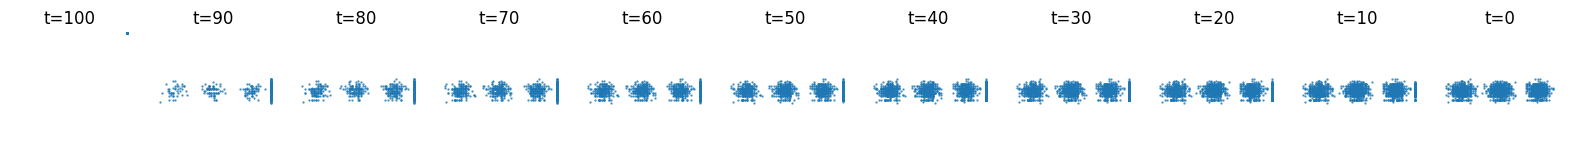

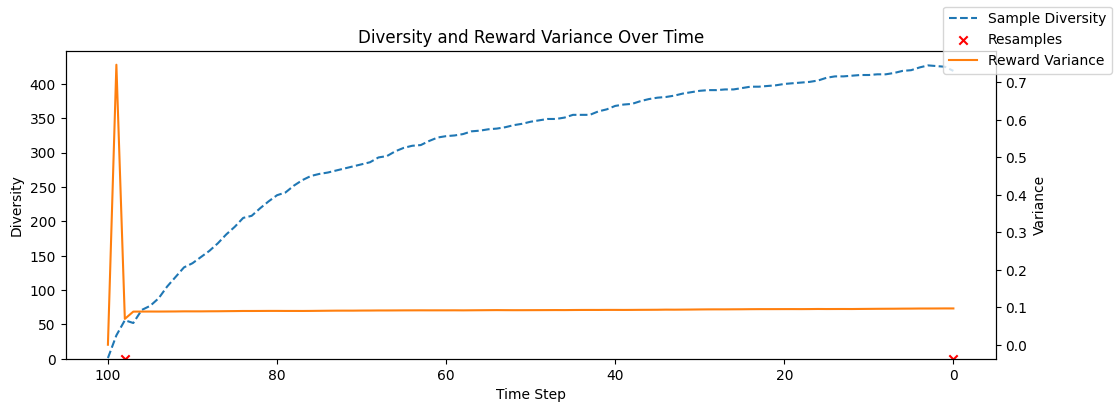

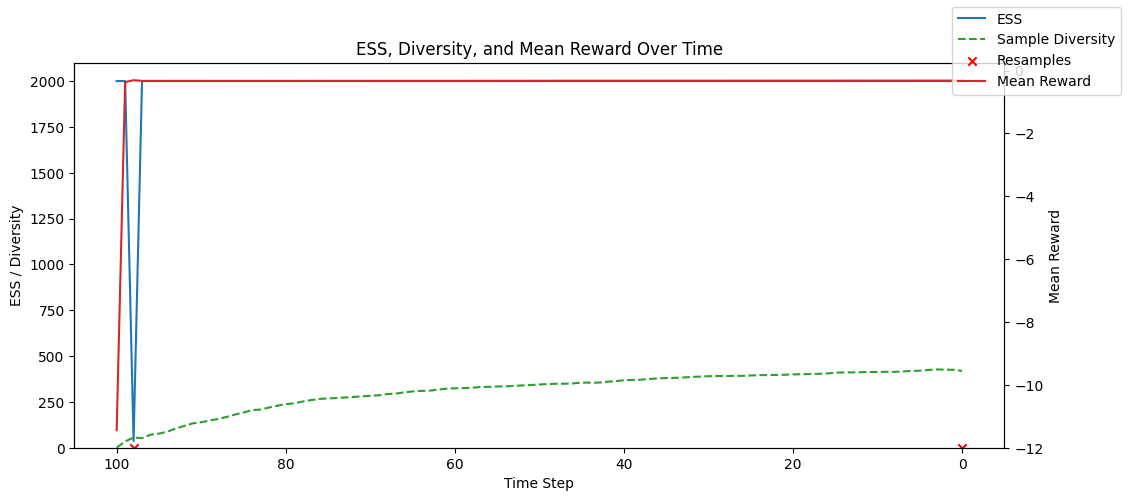

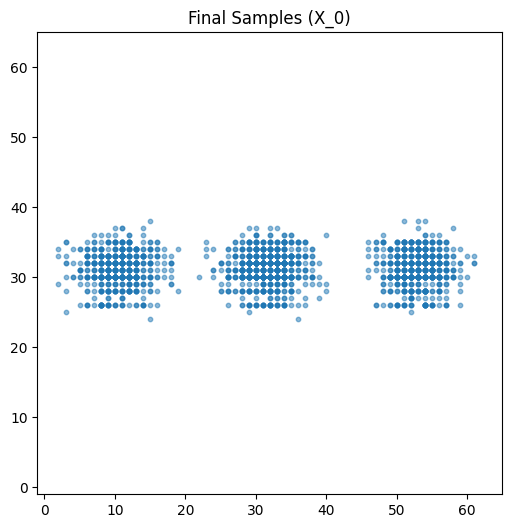

Final average reward: -0.3185
Final diversity: 419
EMD: 1.0669361331951517


100%|██████████| 100/100 [00:01<00:00, 98.82it/s]


Resampled 2 times.


100%|██████████| 100/100 [00:01<00:00, 97.07it/s]


Resampled 3 times.


100%|██████████| 100/100 [00:00<00:00, 107.56it/s]


Resampled 2 times.


100%|██████████| 100/100 [00:00<00:00, 104.97it/s]


Resampled 2 times.


100%|██████████| 100/100 [00:00<00:00, 113.18it/s]


Resampled 2 times.


100%|██████████| 100/100 [00:00<00:00, 103.76it/s]


Resampled 2 times.


100%|██████████| 100/100 [00:00<00:00, 100.13it/s]


Resampled 2 times.


100%|██████████| 100/100 [00:00<00:00, 103.88it/s]


Resampled 2 times.


100%|██████████| 100/100 [00:01<00:00, 99.34it/s]


Resampled 2 times.


100%|██████████| 10/10 [04:33<00:00, 27.32s/it]


In [14]:
for run in tqdm(range(runs_per_method)):
    results = sequential_monte_carlo(
        model=pretrained_model,
        num_categories=num_categories,
        T=num_timesteps,
        N=num_particles,
        ESS_min=ESS_min,
        intialize_particles_fn=intialize_particles,
        resample_fn=systematic_resample,
        proposal_fn=locally_optimal_proposal,
        compute_reward_fn=compute_rewards,
        compute_reward_from_probs=compute_reward_for_x0_pred,
        lambdas=lambdas,
        kl_weight=kl_weight,
        reward_estimate=reward_estimate,
        reward_estimate_sample_count=reward_estimate_sample_count,
        perform_final_resample=perform_final_resample,
        device=device,
        verbose=False,
    )
    # Plot for one of the runs
    if run == 0:
        plot_smc_results_checkerboard(results, num_timesteps, vocab_size, num_categories, compute_rewards, target_samples=target_samples)
    samples = results["X_0"].cpu().numpy()
    rewards = compute_rewards(F.one_hot(torch.tensor(samples), num_classes=num_categories).float()).mean()
    diversity = np.unique(samples, axis=0).shape[0]
    emd = calculate_EMD(samples, target_samples)
    all_experiment_results[SMC_LOP].append(
        {
            "results": results,
            "metrics": {
                "reward": rewards.item(),
                "diversity": diversity,
                "emd": emd
            }
        }
    )

In [15]:
summarize_metrics(all_experiment_results[SMC_LOP])

Number of runs: 10
Reward: -0.29 ± 0.03
Diversity: 387.50 ± 21.41
EMD: 1.80 ± 0.64
Resample Count: 1.10 ± 0.30


## SMC-RP

100%|██████████| 100/100 [00:00<00:00, 193.53it/s]


Resampled 4 times.


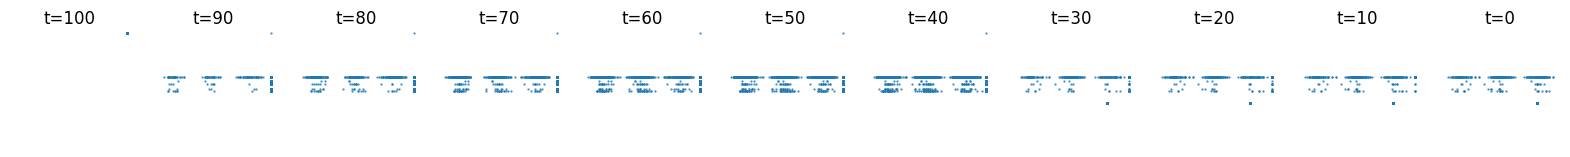

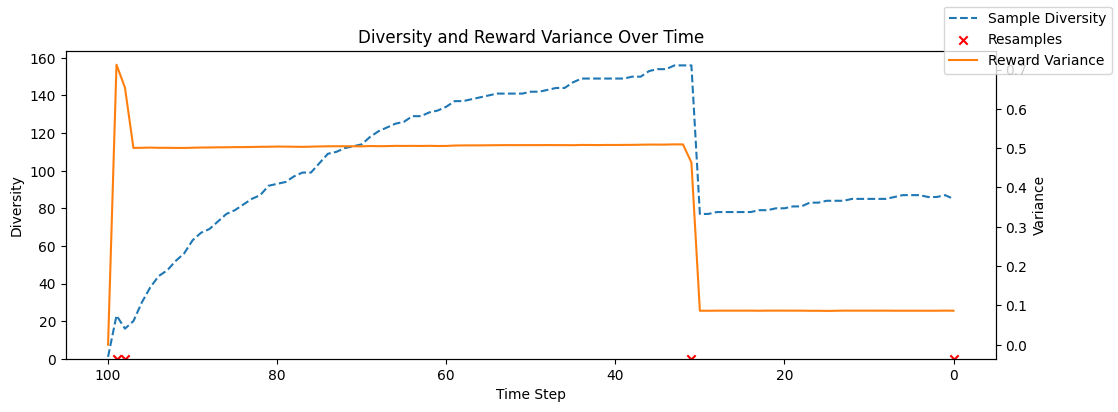

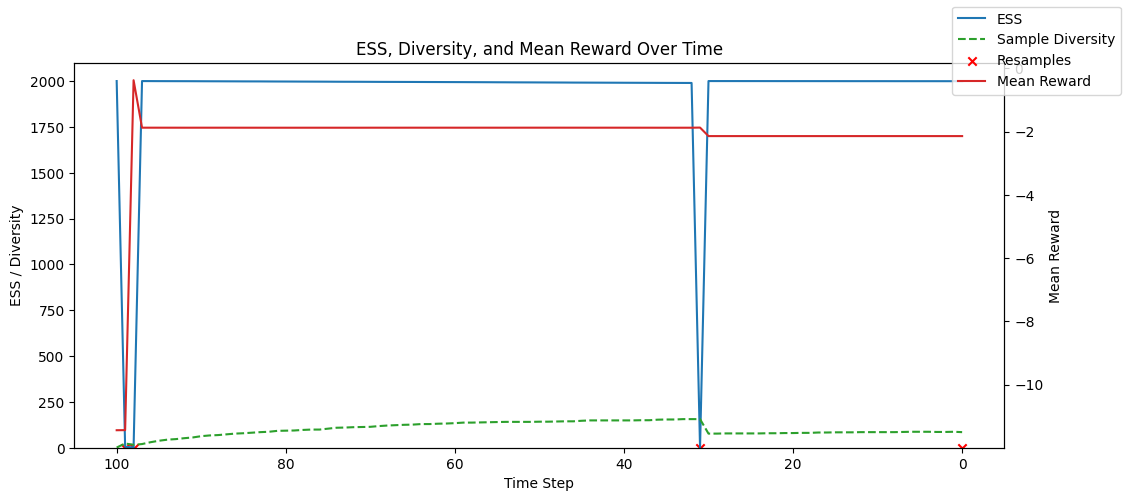

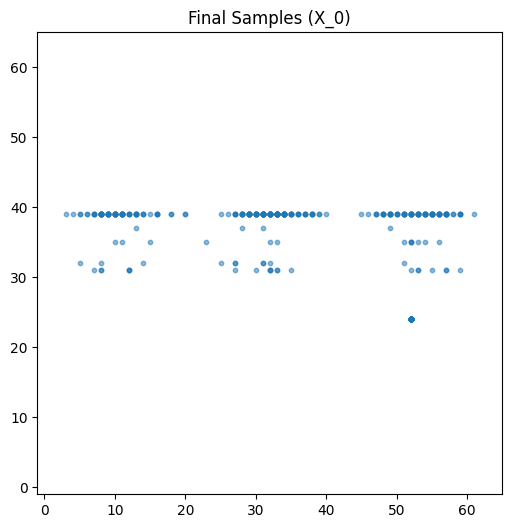

Final average reward: -2.1410
Final diversity: 85
EMD: 20.025246028973687


100%|██████████| 100/100 [00:00<00:00, 187.98it/s]


Resampled 3 times.


100%|██████████| 100/100 [00:00<00:00, 163.39it/s]


Resampled 3 times.


100%|██████████| 100/100 [00:00<00:00, 164.18it/s]


Resampled 3 times.


100%|██████████| 100/100 [00:00<00:00, 142.89it/s]


Resampled 3 times.


100%|██████████| 100/100 [00:00<00:00, 146.30it/s]


Resampled 3 times.


100%|██████████| 100/100 [00:00<00:00, 141.07it/s]


Resampled 3 times.


100%|██████████| 100/100 [00:00<00:00, 231.19it/s]


Resampled 3 times.


100%|██████████| 100/100 [00:00<00:00, 159.61it/s]


Resampled 3 times.


100%|██████████| 100/100 [00:00<00:00, 155.72it/s]


Resampled 3 times.


100%|██████████| 10/10 [02:32<00:00, 15.27s/it]


In [16]:
for run in tqdm(range(runs_per_method)):
    results = sequential_monte_carlo(
        model=pretrained_model,
        num_categories=num_categories,
        T=num_timesteps,
        N=num_particles,
        ESS_min=ESS_min,
        intialize_particles_fn=intialize_particles,
        resample_fn=systematic_resample,
        proposal_fn=reverse_as_proposal,
        compute_reward_fn=compute_rewards,
        compute_reward_from_probs=compute_reward_for_x0_pred,
        lambdas=lambdas,
        kl_weight=kl_weight,
        reward_estimate=reward_estimate,
        reward_estimate_sample_count=reward_estimate_sample_count,
        perform_final_resample=perform_final_resample,
        device=device,
        verbose=False,
    )
    if run == 0:
        plot_smc_results_checkerboard(results, num_timesteps, vocab_size, num_categories, compute_rewards, target_samples=target_samples)
    samples = results["X_0"].cpu().numpy()
    rewards = compute_rewards(F.one_hot(torch.tensor(samples), num_classes=num_categories).float()).mean()
    diversity = np.unique(samples, axis=0).shape[0]
    emd = calculate_EMD(samples, target_samples)
    all_experiment_results[SMC_RP].append(
        {
            "results": results,
            "metrics": {
                "reward": rewards.item(),
                "diversity": diversity,
                "emd": emd
            }
        }
    )

In [17]:
summarize_metrics(all_experiment_results[SMC_RP])

Number of runs: 10
Reward: -0.46 ± 0.56
Diversity: 83.70 ± 17.57
EMD: 8.29 ± 8.15
Resample Count: 2.10 ± 0.30


## SMC-FALOP

100%|██████████| 100/100 [00:00<00:00, 115.45it/s]


Resampled 2 times.


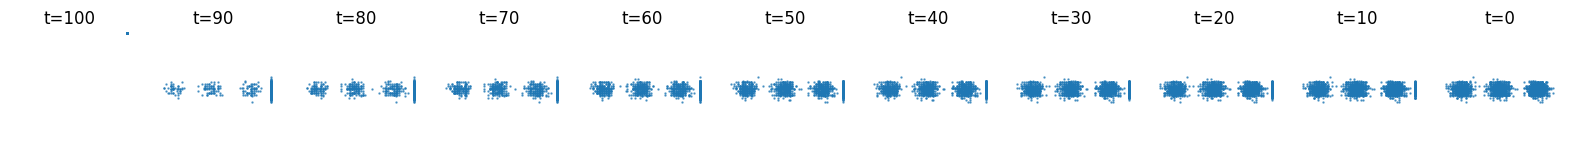

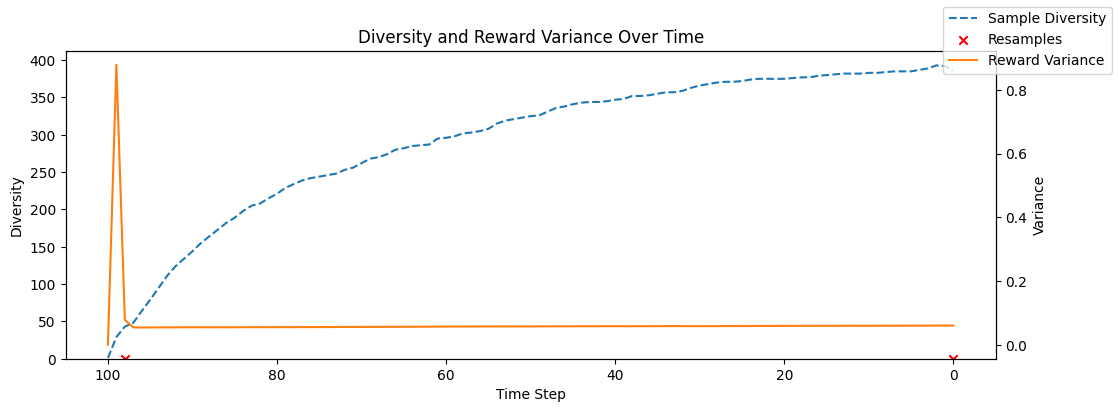

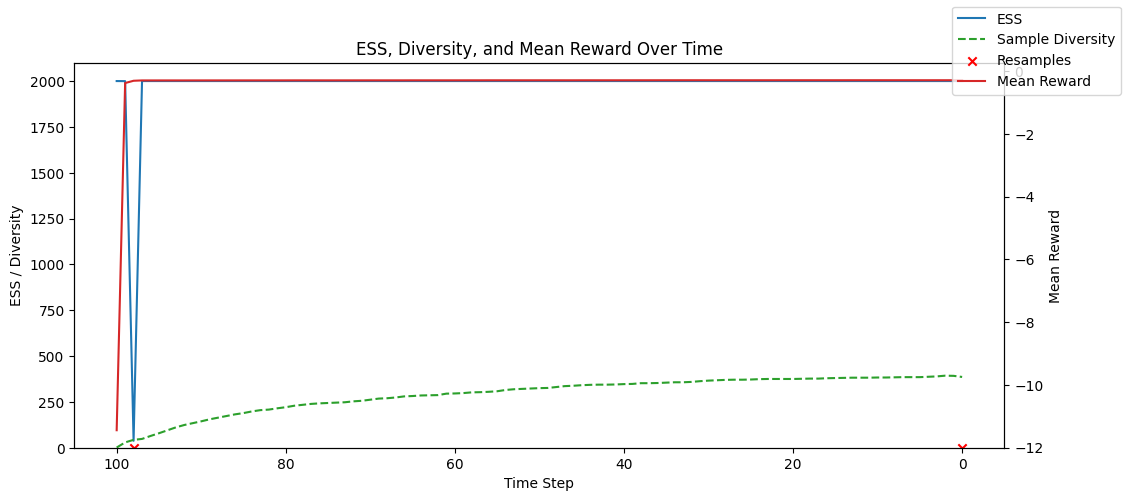

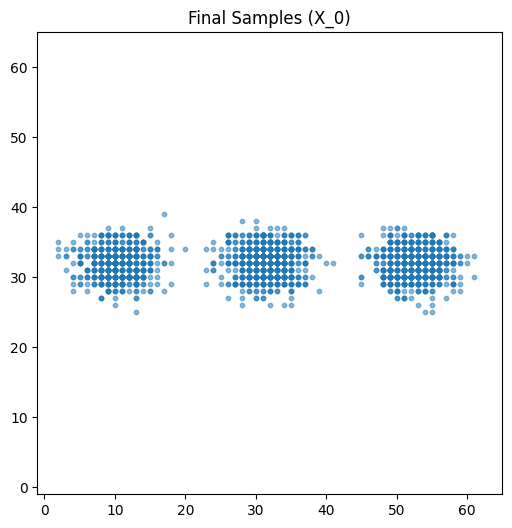

Final average reward: -0.2902
Final diversity: 386


EMD: 1.3818975470797867


100%|██████████| 100/100 [00:00<00:00, 109.27it/s]


Resampled 2 times.


100%|██████████| 100/100 [00:00<00:00, 113.43it/s]


Resampled 2 times.


100%|██████████| 100/100 [00:00<00:00, 123.86it/s]


Resampled 2 times.


100%|██████████| 100/100 [00:00<00:00, 116.52it/s]


Resampled 2 times.


100%|██████████| 100/100 [00:00<00:00, 114.12it/s]


Resampled 2 times.


100%|██████████| 100/100 [00:01<00:00, 97.79it/s]


Resampled 2 times.


100%|██████████| 100/100 [00:01<00:00, 91.75it/s]


Resampled 2 times.


100%|██████████| 100/100 [00:00<00:00, 108.14it/s]


Resampled 2 times.


100%|██████████| 100/100 [00:00<00:00, 118.22it/s]


Resampled 2 times.


100%|██████████| 10/10 [04:32<00:00, 27.21s/it]


In [18]:
for run in tqdm(range(runs_per_method)):
    results = sequential_monte_carlo(
        model=pretrained_model_with_subs_continuous,
        num_categories=num_categories,
        T=num_timesteps,
        N=num_particles,
        ESS_min=ESS_min,
        intialize_particles_fn=intialize_particles,
        resample_fn=systematic_resample,
        proposal_fn=first_order_approximation_optimal_proposal,
        compute_reward_fn=compute_rewards,
        compute_reward_from_probs=compute_reward_for_x0_pred,
        lambdas=lambdas,
        kl_weight=kl_weight,
        reward_estimate=reward_estimate,
        reward_estimate_sample_count=reward_estimate_sample_count,
        perform_final_resample=perform_final_resample,
        device=device,
        verbose=False,
    )
    if run == 0:
        plot_smc_results_checkerboard(results, num_timesteps, vocab_size, num_categories, compute_rewards, target_samples=target_samples)
    samples = results["X_0"].cpu().numpy()
    rewards = compute_rewards(F.one_hot(torch.tensor(samples), num_classes=num_categories).float()).mean()
    diversity = np.unique(samples, axis=0).shape[0]
    emd = calculate_EMD(samples, target_samples)
    all_experiment_results[SMC_FALOP].append(
        {
            "results": results,
            "metrics": {
                "reward": rewards.item(),
                "diversity": diversity,
                "emd": emd
            }
        }
    )

In [19]:
summarize_metrics(all_experiment_results[SMC_FALOP])

Number of runs: 10
Reward: -0.28 ± 0.01
Diversity: 383.20 ± 18.70
EMD: 1.58 ± 0.43
Resample Count: 1.00 ± 0.00


In [ ]:
# Final summary
for method, results in all_experiment_results.items():
    print(f"Method: {method}")
    summarize_metrics(results)
    print()

Method: BASE_MODEL
Number of runs: 0
Reward: nan ± nan
Diversity: nan ± nan
EMD: nan ± nan
Resample Count: nan ± nan

Method: SMC_LOP
Number of runs: 10
Reward: -0.29 ± 0.03
Diversity: 387.50 ± 21.41
EMD: 1.80 ± 0.64
Resample Count: 1.10 ± 0.30

Method: SMC_RP
Number of runs: 10
Reward: -0.46 ± 0.56
Diversity: 83.70 ± 17.57
EMD: 8.29 ± 8.15
Resample Count: 2.10 ± 0.30

Method: SMC_FALOP
Number of runs: 10
Reward: -0.28 ± 0.01
Diversity: 383.20 ± 18.70
EMD: 1.58 ± 0.43
Resample Count: 1.00 ± 0.00

Method: TARGET
Number of runs: 1
Reward: -0.30 ± 0.00
Diversity: 432.00 ± 0.00
EMD: 0.00 ± 0.00
Resample Count: 0.00 ± 0.00



/home/zo122/CHINMAY/discrete-diffusion-smc-experiments/venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zo122/CHINMAY/discrete-diffusion-smc-experiments/venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zo122/CHINMAY/discrete-diffusion-smc-experiments/venv/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zo122/CHINMAY/discrete-diffusion-smc-experiments/venv/lib/python3.10/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/zo122/CHINMAY/discrete-diffusion-smc-experiments/venv/lib/python3.10/site-packages/numpy/_core/_methods.py:215: Runtim

### Dump all experiment results to disk

In [21]:
import pickle
# write to disk
with open(os.path.join(outputs_dir, "all_experiments.pkl"), "wb") as f:
    pickle.dump(all_experiment_results, f)
    
# how to read from disk
# ... = pickle.load(open(os.path.join(outputs_dir, "all_experiments.pkl"), "rb"))